# Classification example using TabSRALinear and stability study: Heloc Fico dataset
 https://community.fico.com/s/explainable-machine-learning-challenge .


## Librairies 

In [1]:
import os, sys, time
import numpy as np
import pandas as pd

In [2]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

In [3]:
import torch 
import torch.nn as nn
import torch.optim as optim 

In [4]:
sys.path.append('../')
from SRAModels import TabSRALinear,LR
from DataProcessing import load_benchmark
from utils import TrainModel,reset_seed_,Predict, load, save,LinearScaling


## Data loading

In [5]:
n_cats, n , feature_names, n_features,n_classes, datasets = load_benchmark( data_path='../Datasets/',name='HelocFico')

In [6]:
len(datasets),n_features,n_classes,n_cats, n 

(5, 23, 2, 0, 10459)

In [7]:
## We use only the first fold (ie ind =0)
ind_fold =0
X_train_, X_test_, Y_train_, Y_test_ = datasets[ind_fold]
Y_train_[:,1].mean(),Y_test_[:,1].mean()

(0.4780686028445082, 0.4780114722753346)

## Model: LR (Logistic Regression) 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
train_set = torch.utils.data.TensorDataset(torch.Tensor(X_train_), torch.Tensor(Y_train_[:,1]))
val_set = torch.utils.data.TensorDataset(torch.Tensor(X_test_), torch.Tensor(Y_test_[:,1]))

In [10]:
## function to build the model
def buildLR(static_params):
    Model = LR(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   bias = static_params['bias'],
                   for_classif=True
                  )
    return Model

In [11]:
static_params_LR = {'dim_input':n_features, 'dim_output':n_classes-1, 'bias':True}

In [12]:
%%time
reset_seed_(42)
SimpleLR = buildLR(static_params_LR)
save_model_dir= f'LR_HelocFico_fold_{ind_fold}'
SimpleLR = TrainModel(SimpleLR, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= 500,
                   batch_size = 256,
                   lr = 0.007143256650213327,
                   eval_every = 5,
                   weight_decay = 5.348330773994543e-06,
                   verbose=1,
                   load_best_eval=True
                   )

epoch = 0--AUCROC perf = 0.7513608058608059 -- AUCPR perf = 0.7273212328044081
epoch = 5--AUCROC perf = 0.7781465201465202 -- AUCPR perf = 0.7539356727904821
epoch = 10--AUCROC perf = 0.7782921245421245 -- AUCPR perf = 0.7560767579222482
epoch = 15--AUCROC perf = 0.779901098901099 -- AUCPR perf = 0.7570956757305148
epoch = 20--AUCROC perf = 0.7747005494505494 -- AUCPR perf = 0.7558198369665381
epoch = 25--AUCROC perf = 0.7806236263736264 -- AUCPR perf = 0.7580333984158212
epoch = 30--AUCROC perf = 0.7800650183150183 -- AUCPR perf = 0.7576378660680538
epoch = 35--AUCROC perf = 0.7805453296703296 -- AUCPR perf = 0.7578449749369391
epoch = 40--AUCROC perf = 0.7800686813186812 -- AUCPR perf = 0.7570710588774775
epoch = 45--AUCROC perf = 0.780856227106227 -- AUCPR perf = 0.7581564773394103
epoch = 50--AUCROC perf = 0.7798058608058607 -- AUCPR perf = 0.757749745855888
epoch = 55--AUCROC perf = 0.7811327838827837 -- AUCPR perf = 0.75795726845461
epoch = 60--AUCROC perf = 0.7810888278388279 --

In [13]:
# Inference on the test set.
pred_lr = Predict(SimpleLR,val_set[:][0],device=device)
best_aucroc_lr = roc_auc_score(Y_test_[:,1], pred_lr) 
best_aurpr_lr = average_precision_score(Y_test_[:,1], pred_lr) 
print(f"--AUCROC perf = {best_aucroc_lr} -- AUCPR perf = {best_aurpr_lr}")

--AUCROC perf = 0.7815590659340659 -- AUCPR perf = 0.7583322455629666


## Model: TabSRALinear 

In [14]:
## function to build the model
def buildTabSRA(config_opt,static_params):
    Model = TabSRALinear(dim_input = static_params['dim_input'],
                   dim_output = static_params['dim_output'],
                   dim_head = config_opt['dim_head'],
                   get_attention = static_params['get_attention'],
                   dropout_rate = config_opt['dropout_rate'],
                   activation = static_params['activation'],
                   bias = static_params['bias'],
                   s =  LinearScaling(scale = config_opt['dim_head']**-0.5)
                  )
    return Model

In [15]:
## The hyperparameters are already optimized (using optuna) 
config_opt = {'lr': 0.007088794143401869, 'dropout_rate': 0.4, 'dim_head': 12, 'epochs': 500, 'weight_decay': 0.0008406966545365837, 'batch_size': 1280}
static_params = {'dim_input':n_features, 'dim_output':n_classes-1,'get_attention':True, 'activation':nn.ReLU(), 'bias':True}


In [16]:
%%time
reset_seed_(42)
Model = buildTabSRA(config_opt,static_params)
save_model_dir= f'TabSRALinear_HelocFico_fold_{ind_fold}'
Model = TrainModel(Model, 
                   train_set = train_set,
                   test_set=val_set,
                   save_path=save_model_dir,
                   device = device,
                   epochs= config_opt['epochs'],
                   batch_size = config_opt['batch_size'],
                   lr = config_opt['lr'],
                   eval_every = 5,
                   weight_decay = config_opt['weight_decay'],
                   verbose=1,
                   load_best_eval=True,
                   eval_metric='AUCROC'
                   )

epoch = 0--AUCROC perf = 0.7340347985347985 -- AUCPR perf = 0.7071527033730813
epoch = 5--AUCROC perf = 0.7821529304029303 -- AUCPR perf = 0.7588698139702549
epoch = 10--AUCROC perf = 0.7861959706959707 -- AUCPR perf = 0.7679115204575558
epoch = 15--AUCROC perf = 0.7884294871794871 -- AUCPR perf = 0.7713385189593828
epoch = 20--AUCROC perf = 0.7893424908424908 -- AUCPR perf = 0.7717109491606347
epoch = 25--AUCROC perf = 0.7897445054945055 -- AUCPR perf = 0.7709283658591303
epoch = 30--AUCROC perf = 0.790624542124542 -- AUCPR perf = 0.7727513656264172
epoch = 35--AUCROC perf = 0.7905274725274726 -- AUCPR perf = 0.7727438958268287
epoch = 40--AUCROC perf = 0.7902673992673992 -- AUCPR perf = 0.7721990087136963
epoch = 45--AUCROC perf = 0.7919056776556777 -- AUCPR perf = 0.7743335788006143
epoch = 50--AUCROC perf = 0.7924065934065935 -- AUCPR perf = 0.7738406523323575
epoch = 55--AUCROC perf = 0.7910943223443225 -- AUCPR perf = 0.7720667949055172
epoch = 60--AUCROC perf = 0.791017399267399

In [17]:
# Inference on the test set. the Predict function will return the ouptut scores and the attention weights as Model.get_attention is True
att,pred_tabsra = Predict(Model,val_set[:][0],device=device)

best_aucroc_tabsra = roc_auc_score(Y_test_[:,1], pred_tabsra) 
best_aucpr_tabsra = average_precision_score(Y_test_[:,1], pred_tabsra) 
print(f"--AUCROC perf = {best_aucroc_tabsra} -- AUCPR perf = {best_aucpr_tabsra}")

--AUCROC perf = 0.7927916666666666 -- AUCPR perf = 0.7754709759948994


## Model: XGBoost 

In [18]:
from xgboost import XGBClassifier


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [19]:
def buildXGBoost(config_opt,static_params):
    config_opt.update(static_params)
    model_xgb = XGBClassifier(**config_opt)
    return model_xgb

In [20]:
### These parameters are optimized using 30 trials with optuna (bayesian optimization)
config_opt_xgb = {
              'eta': 0.0054836062607363095,
              'max_depth': 4,
              'colsample_bytree': 1.0,
              'subsample': 0.8,
              'n_estimators': 1100,
              'min_child_weight':22

              }
static_params_xgb = {
                 'random_state':42,
                 'objective': 'binary:logistic',
                 'n_jobs': -1,
}


In [21]:
model_xgb = buildXGBoost(config_opt=config_opt_xgb,static_params=static_params_xgb)
eval_set = [(X_test_, Y_test_[:,1])]
model_xgb.fit(X_train_, Y_train_[:,1], eval_metric=['auc','aucpr'], eval_set=eval_set, verbose=1)

[0]	validation_0-auc:0.76185	validation_0-aucpr:0.71860
[1]	validation_0-auc:0.76534	validation_0-aucpr:0.72394
[2]	validation_0-auc:0.77335	validation_0-aucpr:0.73760
[3]	validation_0-auc:0.77564	validation_0-aucpr:0.73961
[4]	validation_0-auc:0.77663	validation_0-aucpr:0.74164
[5]	validation_0-auc:0.77732	validation_0-aucpr:0.74243
[6]	validation_0-auc:0.77850	validation_0-aucpr:0.74401
[7]	validation_0-auc:0.77850	validation_0-aucpr:0.74557
[8]	validation_0-auc:0.77871	validation_0-aucpr:0.74605


/home/kodjo/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[9]	validation_0-auc:0.77886	validation_0-aucpr:0.74627
[10]	validation_0-auc:0.77786	validation_0-aucpr:0.74499
[11]	validation_0-auc:0.77759	validation_0-aucpr:0.74447
[12]	validation_0-auc:0.77786	validation_0-aucpr:0.74686
[13]	validation_0-auc:0.77783	validation_0-aucpr:0.74714
[14]	validation_0-auc:0.77731	validation_0-aucpr:0.74565
[15]	validation_0-auc:0.77761	validation_0-aucpr:0.74618
[16]	validation_0-auc:0.77700	validation_0-aucpr:0.74576
[17]	validation_0-auc:0.77725	validation_0-aucpr:0.74614
[18]	validation_0-auc:0.77819	validation_0-aucpr:0.74679
[19]	validation_0-auc:0.77835	validation_0-aucpr:0.74709
[20]	validation_0-auc:0.77916	validation_0-aucpr:0.75024
[21]	validation_0-auc:0.77923	validation_0-aucpr:0.75065
[22]	validation_0-auc:0.77908	validation_0-aucpr:0.75051
[23]	validation_0-auc:0.77932	validation_0-aucpr:0.75058
[24]	validation_0-auc:0.77939	validation_0-aucpr:0.75057
[25]	validation_0-auc:0.77923	validation_0-aucpr:0.75036
[26]	validation_0-auc:0.77962	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eta=0.0054836062607363095, gamma=0,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.00548360636, max_delta_step=0, max_depth=4,
              min_child_weight=22, missing=nan, monotone_constraints='()',
              n_estimators=1100, n_jobs=-1, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [22]:
# Inference for xgboost 
pred_xgboost = model_xgb.predict_proba(X_test_)[:,1]
best_aucroc_xgb = roc_auc_score(Y_test_[:,1], pred_xgboost) 
best_aurpr_xgb = average_precision_score(Y_test_[:,1], pred_xgboost) 
print(f"--AUCROC perf = {best_aucroc_xgb} -- AUCPR perf = {best_aurpr_xgb}")

--AUCROC perf = 0.7973836996336997 -- AUCPR perf = 0.7817357609400266


## Interpretability: Lipschitz estimate 
We want to estimate the quantity:
\begin{equation} \label{eqn:LipschitzEstimate}
\begin{split}
\hat{L}(x) & = \underset{x' \in \mathcal{N}_{\epsilon}(x)}{\arg\max} \lVert   f_{expl}(\mathbf x) - f_{expl}(\mathbf x') \lVert_2/\lVert  \mathbf x - \mathbf x' \lVert_2
\end{split}
 \end{equation}

- For the LR (Logistic Regression), this quantity is equivalent to $\lVert \boldsymbol\beta \lVert_{\infty}$
- For TabSRALinear, it is proportional to $\lVert \boldsymbol\beta \lVert_{\infty} ( \lVert  \mathbf a \lVert_{\infty} + L_a\lVert \mathbf x \lVert_{\infty} )$ and  $L_a>0$ the Lipschitz constant of the SRA block (see the paper for more details). With our implementation $s(x) = x/\sqrt{d_k}$ therefore $\mathbf a \in [0,1]$ and $\lVert  \mathbf a \lVert_{\infty}=1$. We recall that $d_k$ is the dim_head  parameter.

In [23]:
%%time
attributions_lr = pd.DataFrame(SimpleLR.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_lr.columns = feature_names
attributions_lr['pred_proba'] = pred_lr
attributions_lr['label'] = val_set[:][1].numpy()

CPU times: user 0 ns, sys: 22 ms, total: 22 ms
Wall time: 1.47 ms


In [24]:
%%time
attributions_tabsra = pd.DataFrame(att*Model.classifier.weight.data.to('cpu').numpy().ravel()*val_set[:][0].numpy())
attributions_tabsra.columns = feature_names
attributions_tabsra['pred_proba'] = pred_tabsra
attributions_tabsra['label'] = val_set[:][1].numpy()

CPU times: user 12.3 ms, sys: 6.27 ms, total: 18.5 ms
Wall time: 1.25 ms


In [25]:
%%time
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test_)
attributions_xgb = pd.DataFrame(shap_values.values)
attributions_xgb.columns = feature_names
attributions_xgb['pred_proba'] = pred_xgboost
attributions_xgb['label'] = val_set[:][1].numpy()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 6.44 s, sys: 1.73 s, total: 8.17 s
Wall time: 1.37 s


**Consider data points of class 1 (ie label ==1)**

In [26]:
attributions_lr_tmp = attributions_lr[attributions_lr.label==1]
attributions_tabsra_tmp = attributions_tabsra[attributions_tabsra.label==1]
attributions_xgb_tmp = attributions_xgb[attributions_xgb.label==1]

In [27]:
len(attributions_lr_tmp), len(attributions_tabsra_tmp),len(attributions_xgb_tmp)

(1000, 1000, 1000)

In [28]:
X_test_df = pd.DataFrame(X_test_)
X_test_df.columns = feature_names

In [29]:
X_test_df_tmp = pd.merge(attributions_tabsra_tmp[["pred_proba", "label"]], X_test_df, left_index=True, right_index=True)

In [30]:
alpha_std = 1e-2 # the standard deviation of the Gaussiann_pertub = 100
n_pertub = 100
#n_features = len(feature_names)

In [31]:
np.random.seed(42)
X_test_ref = X_test_df_tmp[feature_names].values

X_attrib_lr = attributions_lr_tmp[feature_names].values
pred_lr_tmp = attributions_lr_tmp.pred_proba.values

X_attrib_tabsra = attributions_tabsra_tmp[feature_names].values
pred_tabsra_tmp = attributions_tabsra_tmp.pred_proba.values



X_attrib_xgb = attributions_xgb_tmp[feature_names].values
pred_xgb_tmp = attributions_xgb_tmp.pred_proba.values


tmp_noise =np.random.normal(0,1*alpha_std, n_features*n_pertub).reshape(n_pertub,n_features)
rapport_denom  = np.linalg.norm(tmp_noise,ord=2, axis=1)
n_point = len(X_test_ref)

In [32]:
X_test_ref.shape

(1000, 23)

In [33]:
X_attrib_lr.shape

(1000, 23)

In [34]:
%%time
## LR 
relative_norm_lr = np.zeros(n_point)
relative_pred_lr = np.zeros(n_point)

for i in range(n_point):
    #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
    X_new_np = X_test_ref[i]+tmp_noise
    X_new = torch.Tensor(X_new_np).to(device)
    y_pred_linear = Predict(SimpleLR,X_new,device=device)
    
    X_test1_new_ = np.linalg.norm(X_attrib_lr[i] - X_new_np*SimpleLR.classifier.weight.data.to('cpu').numpy()[0],ord=2,axis=1)
    relative_pred_lr[i] = np.max(np.abs(pred_lr_tmp[i]-y_pred_linear))
    
    relative_norm_lr[i] =  np.max(X_test1_new_/rapport_denom)

CPU times: user 830 ms, sys: 1.22 s, total: 2.05 s
Wall time: 180 ms


In [35]:
%%time
## TAbSRA
relative_norm = np.zeros(n_point)
relative_pred = np.zeros(n_point)

for i in range(n_point):
    #tmp_x =np.random.normal(0,1*alpha_stp, 5*100).reshape(100,5)
    X_new_np = X_test_ref[i]+tmp_noise
    X_new = torch.Tensor(X_new_np).to(device)
    att, y_pred_TabSRA_linear = Predict(Model,X_new,device=device) #Model(X_new)#
    X_test1_new_ = np.linalg.norm(X_attrib_tabsra[i] - att*X_new_np*Model.classifier.weight.data.to('cpu').numpy()[0],ord=2,axis=1)
    relative_pred[i] = np.max(np.abs(pred_tabsra_tmp[i]-y_pred_TabSRA_linear))
    
    relative_norm[i] =  np.max(X_test1_new_/rapport_denom)

CPU times: user 431 ms, sys: 214 µs, total: 432 ms
Wall time: 430 ms


In [36]:
%%time
## XGBoost+TreeSHAP
relative_norm_xgb = np.zeros(n_point)
relative_pred_xgb = np.zeros(n_point)
for i in range(n_point):
    X_new_np = X_test_ref[i]+tmp_noise
    y_pred_xgb  = explainer(X_new_np).values
    y_pred_proba_xgb  = model_xgb.predict_proba(X_new_np)[:,1]

    X_test1_new_ = np.linalg.norm(X_attrib_xgb[i] - y_pred_xgb,ord=2,axis=1)
    
    relative_pred_xgb[i] = np.max(np.abs(pred_xgb_tmp[i]-y_pred_proba_xgb))

    relative_norm_xgb[i] =  np.max(X_test1_new_/rapport_denom)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


CPU times: user 4min 34s, sys: 1min 3s, total: 5min 38s
Wall time: 21.2 s


In [37]:
df_classic_expl = pd.DataFrame()

df_classic_expl["LR"] = relative_norm_lr
df_classic_expl["TabSRALinear"] = relative_norm
df_classic_expl["XGBoost+TreeSHAP"] = relative_norm_xgb

In [38]:
df_classic_output = pd.DataFrame()
df_classic_output["LR"] = relative_pred_lr
df_classic_output["TabSRALinear"] = relative_pred
df_classic_output["XGBoost+TreeSHAP"] = relative_pred_xgb

In [39]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

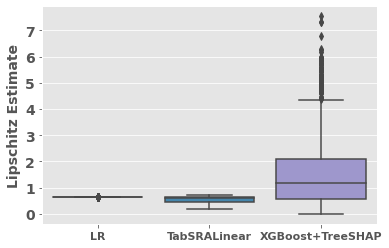

In [40]:
sns.boxplot(data=df_classic_expl)
plt.ylabel("Lipschitz Estimate",weight = 'bold',fontsize=14)
plt.xticks(weight = 'bold',fontsize=11)
plt.yticks(weight = 'bold',fontsize=14)
plt.show()

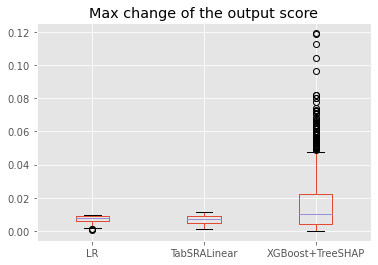

In [41]:
df_classic_output.boxplot();
plt.title('Max change of the output score')
plt.show()